In [1]:
from tqdm import tqdm
import json
from sqlalchemy import func
from sqlalchemy import create_engine, select
from sqlalchemy.orm import Session
from sqlalchemy.orm import aliased

In [2]:
# Import all required data models
from srn_data_collector.annotations_utils.data_model import (
    Base,
    BlobLvlAnnotations,
    BlobLvlAnnotationsModel,
    CompanyDetailsModel,
    CompanyDetailsTable,
    ComplianceItems,
    ComplianceItemsModel,
    DocumentInstances,
    DocumentInstancesModel,
    Indices,
    IndicesModel,
    ReportingRequirements,
    ReportingRequirementsModel,
    RptRequirementsMapping,
    RptRequirementsMappingModel,
    StandardsList,
    StandardsListModel,
    ValuesWithRevisions,
    ValuesWithRevisionsModel,
)

In [3]:
db_path = "/cluster/home/repo/my_llm_experiments/esrs_data_collection/srn_data_collector/main.db"

In [4]:
engine = create_engine(f"sqlite:///{db_path}")
session = Session(engine)

In [5]:
import os
from fnmatch import fnmatch
from tqdm import tqdm

dataset_path = "/cluster/home/srn_storage"

def get_all_files_in_directory(directory):
    with Session(engine) as session:
        docs_objs = session.query(DocumentInstances).all()
        all_files = [f"{doc_obj.company_id}/{doc_obj.year}/{doc_obj.type}/{doc_obj.id}.json" for doc_obj in docs_objs]
    return all_files

In [6]:
all_files = get_all_files_in_directory(dataset_path)

In [7]:
len(all_files)

8335

In [8]:
# Filter by existing docs
all_files_filtered = [file for file in all_files if os.path.exists(os.path.join(dataset_path, file))]

### Dataset visualization

In [9]:
from typing import List, Dict

def get_all_files_in_directory(session, storage_location: str) -> List[str]:
    docs_objs = session.query(DocumentInstances).all()
    all_files = [f"{doc_obj.company_id}/{doc_obj.year}/{doc_obj.type}/{doc_obj.id}.json" for doc_obj in docs_objs]
    return [file for file in all_files if os.path.exists(os.path.join(storage_location, file))]

def get_total_blobs(doc_path):
    with open(doc_path, 'r') as f:
        parsed_doc_data = json.load(f)
    return sum([len(blob_list) for id, blob_list in parsed_doc_data.items()])

def get_annotations(session, doc_id_list: List[str], storage_location: str):
    # Define the SQLAlchemy models
    fvwr = aliased(ValuesWithRevisions)
    dci = aliased(ComplianceItems)
    drr = aliased(ReportingRequirements)
    dcd = aliased(CompanyDetailsTable)
    ddi = aliased(DocumentInstances)
    dbla = aliased(BlobLvlAnnotations)
    mrrsl = aliased(RptRequirementsMapping)
    dsl = aliased(StandardsList)

    # Build the SQLAlchemy query
    stmt = select(
            fvwr.id.label('REVISION_ID'), # 0 
            dsl.family.label('STD_FAMILY'), # 1
            dsl.name.label('STD_NAME'), # 2
            mrrsl.id.label('SOURCE_ID'), # 3
            mrrsl.source.label('REQ_SECTION'), # 4
            dci.name.label('COMPLIANCE_ITEM_NAME'), # 5
            # fvwr.document_ref.label('DOC_PAGE_NO'),
            fvwr.document_id, # 6
            dcd.name.label('COMPANY_NAME'), # 7
            ddi.href.label('DOC_HREF'), # 8
            fvwr.value.label('ORIGINAL_ANNOTATION_TEXT'), # 9
            dbla.blob_text.label('PARSED_DOC_BLOB_TEXT'), # 10
            dbla.blob_class_name, # 11
            dbla.blob_id.label('BLOB_ID'), # 12
        # 13
            dbla.document_ref.label('PAGE_NO'))\
            .join(dci, dci.id == fvwr.compliance_item_id)\
            .join(drr, drr.id == dci.reporting_requirement_id)\
            .join(dcd, dcd.id == fvwr.company_id)\
            .join(ddi, ddi.id == fvwr.document_id)\
            .join(dbla, dbla.revision_id == fvwr.id)\
            .join(mrrsl, drr.id == mrrsl.reporting_requirement_id)\
            .join(dsl, dsl.id == mrrsl.standard)\
            .where(dsl.family.like('%esrs%'))

    # Get the count of all records in above stmt
    count_stmt = select(func.count()).select_from(stmt.alias())
    record_count = session.execute(count_stmt).scalar()
    
    annotations_detailed = session.execute(stmt)
    
    annotation_counts = {os.path.basename(os.path.splitext(doc_id)[0]):{'doc_location': doc_id,
                                                                        "annotated_page_cnt": {},
                                                                        "total_blobs": get_total_blobs(os.path.join(storage_location,doc_id))}
                         for doc_id in tqdm(doc_id_list, desc='initializing annotations_counts')}

    for annotations in tqdm(annotations_detailed, total=record_count, desc="Geting annotation dict"):
        if annotations[13] not in annotation_counts[annotations[6]]["annotated_page_cnt"]:
            annotation_counts[annotations[6]]["annotated_page_cnt"][annotations[13]] = 0
        annotation_counts[annotations[6]]["annotated_page_cnt"][annotations[13]] += 1
    
    return annotation_counts

In [10]:
db_path = "/cluster/home/repo/my_llm_experiments/esrs_data_collection/srn_data_collector/main.db"

dataset_path = "/cluster/home/srn_storage"

json_doc_list = get_all_files_in_directory(session, dataset_path)
annotations = get_annotations(session, json_doc_list, dataset_path)
session.close()

Geting annotation dict: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78079/78079 [00:01<00:00, 43419.60it/s]


In [11]:
# filter out doc with no annotations
annotations_filtered = {doc_id:annotation for doc_id, annotation in annotations.items() if annotation['annotated_page_cnt']}

In [12]:
annotations_data_all = [(doc_id, doc_data['total_blobs'], sum(doc_data['annotated_page_cnt'].values())) for doc_id, doc_data in annotations.items() if doc_data['annotated_page_cnt']]
annotations_data_all = sorted(annotations_data_all, key=lambda x: x[1])

In [113]:
annotations

{'4829ba6c-9174-4523-82a6-f4726704bc38': {'doc_location': '8dee5d4e-2b5d-44c4-a78d-2d5d8dd92df1/2021/AR/4829ba6c-9174-4523-82a6-f4726704bc38.json',
  'annotated_page_cnt': {},
  'total_blobs': 2168},
 '057c1c0d-225b-4269-a11c-950196b749be': {'doc_location': '8dee5d4e-2b5d-44c4-a78d-2d5d8dd92df1/2021/SR/057c1c0d-225b-4269-a11c-950196b749be.json',
  'annotated_page_cnt': {},
  'total_blobs': 938},
 'e99aa64d-93b9-4d8d-a37e-8c903128fe6c': {'doc_location': '8dee5d4e-2b5d-44c4-a78d-2d5d8dd92df1/2022/AR/e99aa64d-93b9-4d8d-a37e-8c903128fe6c.json',
  'annotated_page_cnt': {},
  'total_blobs': 2313},
 '95df1d10-26ac-4bc2-a4b5-41f1698cac24': {'doc_location': '8dee5d4e-2b5d-44c4-a78d-2d5d8dd92df1/2022/SR/95df1d10-26ac-4bc2-a4b5-41f1698cac24.json',
  'annotated_page_cnt': {'90': 57,
   '82': 25,
   '81': 2,
   '86': 29,
   '89': 5,
   '78': 1},
  'total_blobs': 934},
 '643fb89d-8602-4a7b-b28d-9cce653dc5b2': {'doc_location': '4d91e0a8-dc1c-42e0-aab4-69342c634e05/2021/AR/643fb89d-8602-4a7b-b28d-9cce

In [13]:
f"{( len(annotations_data_all) / len(annotations)) * 100}% Annotations present in documents"

'17.5151924375422% Annotations present in documents'

In [14]:
f"Average # of blobs annotated per document : {sum([annot_pgs for _,  _, annot_pgs in annotations_data_all])/ len(annotations_data_all)}"

'Average # of blobs annotated per document : 60.19969159599075'

In [15]:
f"Average # of blobs per document : {sum([total_blobs for _,  total_blobs, _ in annotations_data_all])/ len(annotations_data_all)} "

'Average # of blobs per document : 1387.0370084811102 '

In [18]:
annotations_data_all

[('29e7afb6-7000-4ce2-b83d-a5436666a9aa', 6, 14),
 ('17349109-8c58-4ab8-8357-d8d19b8a4b19', 8, 19),
 ('2cc8b0b0-0f6d-42d8-b769-a837254c6a77', 13, 42),
 ('3bc03d42-d4f9-4b47-947b-54b3f7fb25bf', 15, 38),
 ('91f50643-2f3f-4aac-a4ca-2a24e1c85164', 15, 7),
 ('6e18f3d6-b39c-491f-8230-fc914e53e2a7', 17, 8),
 ('224ced79-ab65-4dfb-b070-9fd713be1b90', 18, 9),
 ('7d14ea2d-bf6c-4f7c-979e-1f8adcd47c98', 19, 77),
 ('fc782e17-750a-4d41-a699-dc414f7abef4', 24, 2),
 ('0a43fee8-0fee-4950-b32d-dfb853c046dd', 25, 16),
 ('c36ef44e-1f46-465e-abe8-8c270d2f6286', 26, 18),
 ('10b849fb-b211-48f9-ba54-e03d0f52e2b3', 28, 47),
 ('b255f726-363d-470e-bfea-6f12b4bd0538', 29, 25),
 ('cc8d9cdd-988d-47d8-a146-63c5d4158031', 32, 4),
 ('a8ec8006-12dd-4bb3-b2f2-9fabd2c5f7e8', 33, 13),
 ('66930be5-a82f-4770-831c-a538014ed1b0', 35, 32),
 ('e94e8843-fb3c-4cf2-90a4-65c9ca06afbe', 36, 2),
 ('628bac07-6196-403e-987b-5986d78e82bb', 38, 20),
 ('b25a6a25-ebf7-41c6-a8d4-de113f916044', 39, 8),
 ('10b4750f-3709-4aa9-8921-33a160cc2c1b'

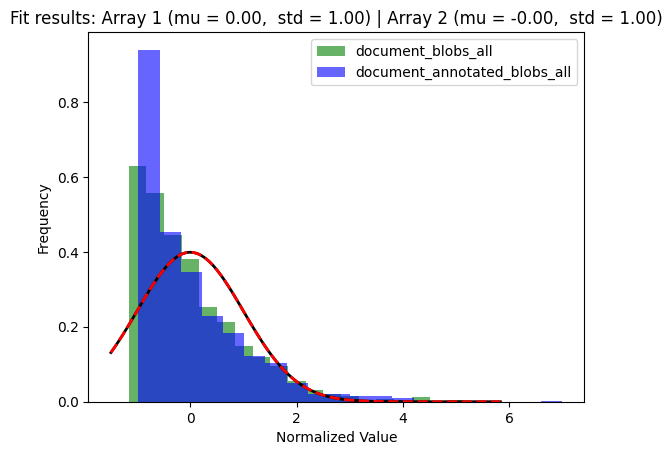

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


array1 = [data[1] for data in annotations_data_all]
array2 = [data[2] for data in annotations_data_all]

# Normalize the data using z-score normalization for both arrays
normalized_data1 = (array1 - np.mean(array1)) / np.std(array1)
normalized_data2 = (array2 - np.mean(array2)) / np.std(array2)

# Fit a normal distribution to the normalized data for both arrays
mu1, std1 = norm.fit(normalized_data1)
mu2, std2 = norm.fit(normalized_data2)

# Plot the histogram for array1
plt.hist(normalized_data1, bins=20, density=True, alpha=0.6, color='g', label='document_blobs_all')

# Plot the PDF (Probability Density Function) for array1
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p1 = norm.pdf(x, mu1, std1)
plt.plot(x, p1, 'k', linewidth=2)

# Plot the histogram for array2
plt.hist(normalized_data2, bins=20, density=True, alpha=0.6, color='b', label='document_annotated_blobs_all')

# Plot the PDF (Probability Density Function) for array2
p2 = norm.pdf(x, mu2, std2)
plt.plot(x, p2, 'r--', linewidth=2)

# Add labels and title
plt.title("Fit results: Array 1 (mu = %.2f,  std = %.2f) | Array 2 (mu = %.2f,  std = %.2f)" % (mu1, std1, mu2, std2))
plt.xlabel('Normalized Value')
plt.ylabel('Frequency')

# Add legend
plt.legend()

# Show the plot
plt.show()

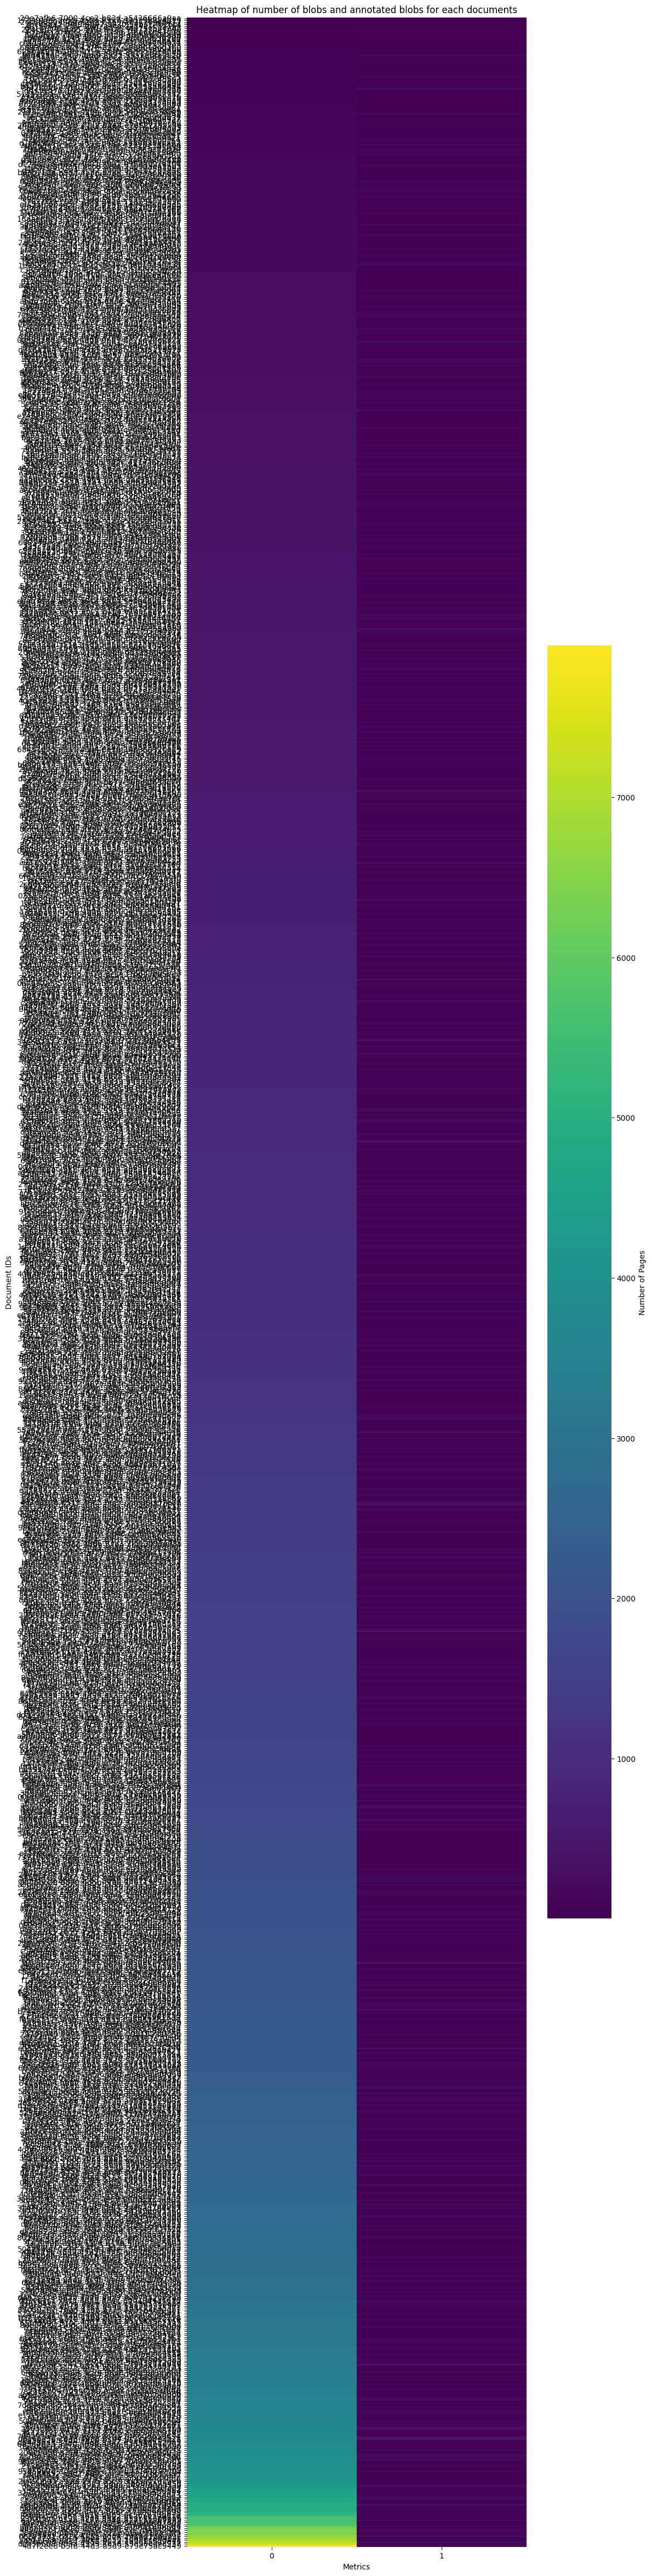

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Sample data
document_ids = [doc_id for doc_id, _, _ in annotations_data_all]
num_pages = [total_blobs for _, total_blobs, _ in annotations_data_all]
num_annotated_pages = [annot_pgs for _, _, annot_pgs in annotations_data_all]

# Creating a matrix for the heatmap
heatmap_data = np.array([num_pages, num_annotated_pages]).T

# create ticks
ytick_interval = 10
yticks = np.arange(1, len(document_ids) + 1, ytick_interval)

# Plotting the heatmap
plt.figure(figsize=(10, 60))
sns.heatmap(heatmap_data, fmt="d", yticklabels=[doc_id for idx, doc_id in enumerate(document_ids)], 
            cmap="viridis", cbar_kws={'label': 'Number of Pages'})

# Adding labels and title
plt.xlabel('Metrics')
plt.ylabel('Document IDs')
plt.title('Heatmap of number of blobs and annotated blobs for each documents')

# Display the plot
plt.show()


In [23]:
with Session(engine) as session:
    active_compliance_items = session.query(ComplianceItems).all()
                              # .filter(ComplianceItems.status == 'active')\

In [24]:
# Define the SQLAlchemy models
fvwr = aliased(ValuesWithRevisions)
dci = aliased(ComplianceItems)
drr = aliased(ReportingRequirements)
dcd = aliased(CompanyDetailsTable)
ddi = aliased(DocumentInstances)
dbla = aliased(BlobLvlAnnotations)
mrrsl = aliased(RptRequirementsMapping)
dsl = aliased(StandardsList)

# Build the SQLAlchemy query
stmt = select(
        fvwr.id.label('REVISION_ID'), # 0 
        dsl.family.label('STD_FAMILY'), # 1
        dsl.name.label('STD_NAME'), # 2
        mrrsl.id.label('SOURCE_ID'), # 3
        mrrsl.source.label('REQ_SECTION'), # 4
        dci.name.label('COMPLIANCE_ITEM_NAME'), # 5
        # fvwr.document_ref.label('DOC_PAGE_NO'),
        fvwr.document_id, # 6
        dcd.name.label('COMPANY_NAME'), # 7
        ddi.href.label('DOC_HREF'), # 8
        fvwr.value.label('ORIGINAL_ANNOTATION_TEXT'), # 9
        dbla.blob_text.label('PARSED_DOC_BLOB_TEXT'), # 10
        dbla.blob_class_name, # 11
        dbla.blob_id.label('BLOB_ID'), # 12
    # 13
        dbla.document_ref.label('PAGE_NO'))\
        .join(dci, dci.id == fvwr.compliance_item_id)\
        .join(drr, drr.id == dci.reporting_requirement_id)\
        .join(dcd, dcd.id == fvwr.company_id)\
        .join(ddi, ddi.id == fvwr.document_id)\
        .join(dbla, dbla.revision_id == fvwr.id)\
        .join(mrrsl, drr.id == mrrsl.reporting_requirement_id)\
        .join(dsl, dsl.id == mrrsl.standard)\
        .where(dsl.family.like('%esrs%'))

annotations_detailed = session.execute(stmt)

compliance_annotation_cnt = {}
for active_compliance_item in active_compliance_items:
    compliance_annotation_cnt[active_compliance_item.name] = 0
for row in annotations_detailed:
    compliance_annotation_cnt[row[5]] += 1

In [25]:
blobs_annotations_category = {}
for doc_id, doc_data in tqdm(annotations.items(), desc = "creating blob class count dict"):
    if doc_id not in blobs_annotations_category:
        blobs_annotations_category[doc_id] = {}
    with open(os.path.join(dataset_path, doc_data['doc_location']), 'r') as f:
        doc_data_json = json.load(f)
        for page_num, doc_data in doc_data_json.items():
            if page_num not in blobs_annotations_category[doc_id]:
                blobs_annotations_category[doc_id][page_num] = {}
            for blob in doc_data:
                if blob['class_name'] not in blobs_annotations_category[doc_id][page_num]:
                    blobs_annotations_category[doc_id][page_num][blob['class_name']] = 0
                blobs_annotations_category[doc_id][page_num][blob['class_name']] += 1

creating blob class count dict: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7405/7405 [01:04<00:00, 114.39it/s]


In [26]:
with Session(engine) as session:
    blob_annotated_category_table = session.query(BlobLvlAnnotations.blob_class_name,ValuesWithRevisions.own_calculation)\
                                    .join(ValuesWithRevisions, ValuesWithRevisions.id == BlobLvlAnnotations.revision_id)\
                                    .filter(BlobLvlAnnotations.blob_class_name == 'table').all()


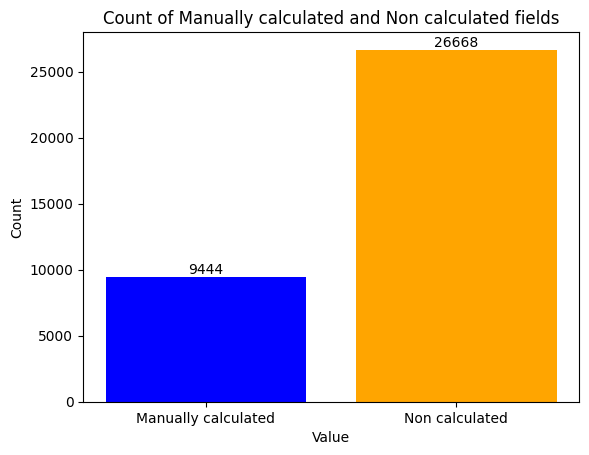

In [27]:
# Extract the True/False values from the third element in each tuple
true_false_values = [item[1] for item in blob_annotated_category_table]

# Count the occurrences of True and False
counts = {'Manually calculated': true_false_values.count(True), 'Non calculated': true_false_values.count(False)}

# Create a bar plot
fig, ax = plt.subplots()
bars = ax.bar(counts.keys(), counts.values(), color=['blue', 'orange'])
plt.title('Count of Manually calculated and Non calculated fields')
plt.xlabel('Value')
plt.ylabel('Count')

# Display the count labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# Display the plot
plt.show()

In [28]:
with Session(engine) as session:
    blob_annotated_category = session.query(ComplianceItems.name, BlobLvlAnnotations.blob_class_name,ValuesWithRevisions.own_calculation,
                                            func.count().label('count')) \
                                            .join(ValuesWithRevisions, ComplianceItems.id == ValuesWithRevisions.compliance_item_id) \
                                            .join(BlobLvlAnnotations, BlobLvlAnnotations.revision_id == ValuesWithRevisions.id) \
                                            .group_by(ComplianceItems.name, BlobLvlAnnotations.blob_class_name) \
                                            .all()

In [29]:
actual_cat_map = {}
for idx, cat_name  in enumerate(blob_annotated_category):
    cat_name = cat_name[0]
    if cat_name not in actual_cat_map:
        actual_cat_map[cat_name] = f"label_{idx}"

In [30]:
len(blob_annotated_category)

1372

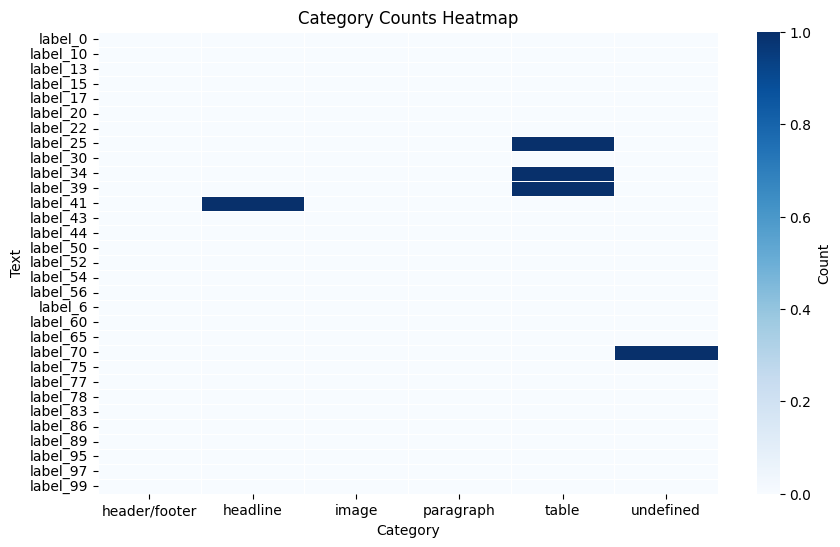

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

data = [(actual_cat_map[cat_items[0]], cat_items[1], cat_items[2]) for cat_items in blob_annotated_category[:100]]

df = pd.DataFrame(data, columns=['Text', 'Category', 'Count'])
pivot_df = df.pivot_table(values='Count', index='Text', columns='Category', aggfunc='sum', fill_value=0)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df, cmap='Blues', fmt='g', linewidths=.5, cbar_kws={"label": "Count"})
plt.title('Category Counts Heatmap')
plt.show()

In [32]:
blobs_cat_counts = {}
for cat_items in blob_annotated_category:
    if actual_cat_map[cat_items[0]] not in blobs_cat_counts:
        blobs_cat_counts[actual_cat_map[cat_items[0]]] = 0
    blobs_cat_counts[actual_cat_map[cat_items[0]]] += cat_items[2]

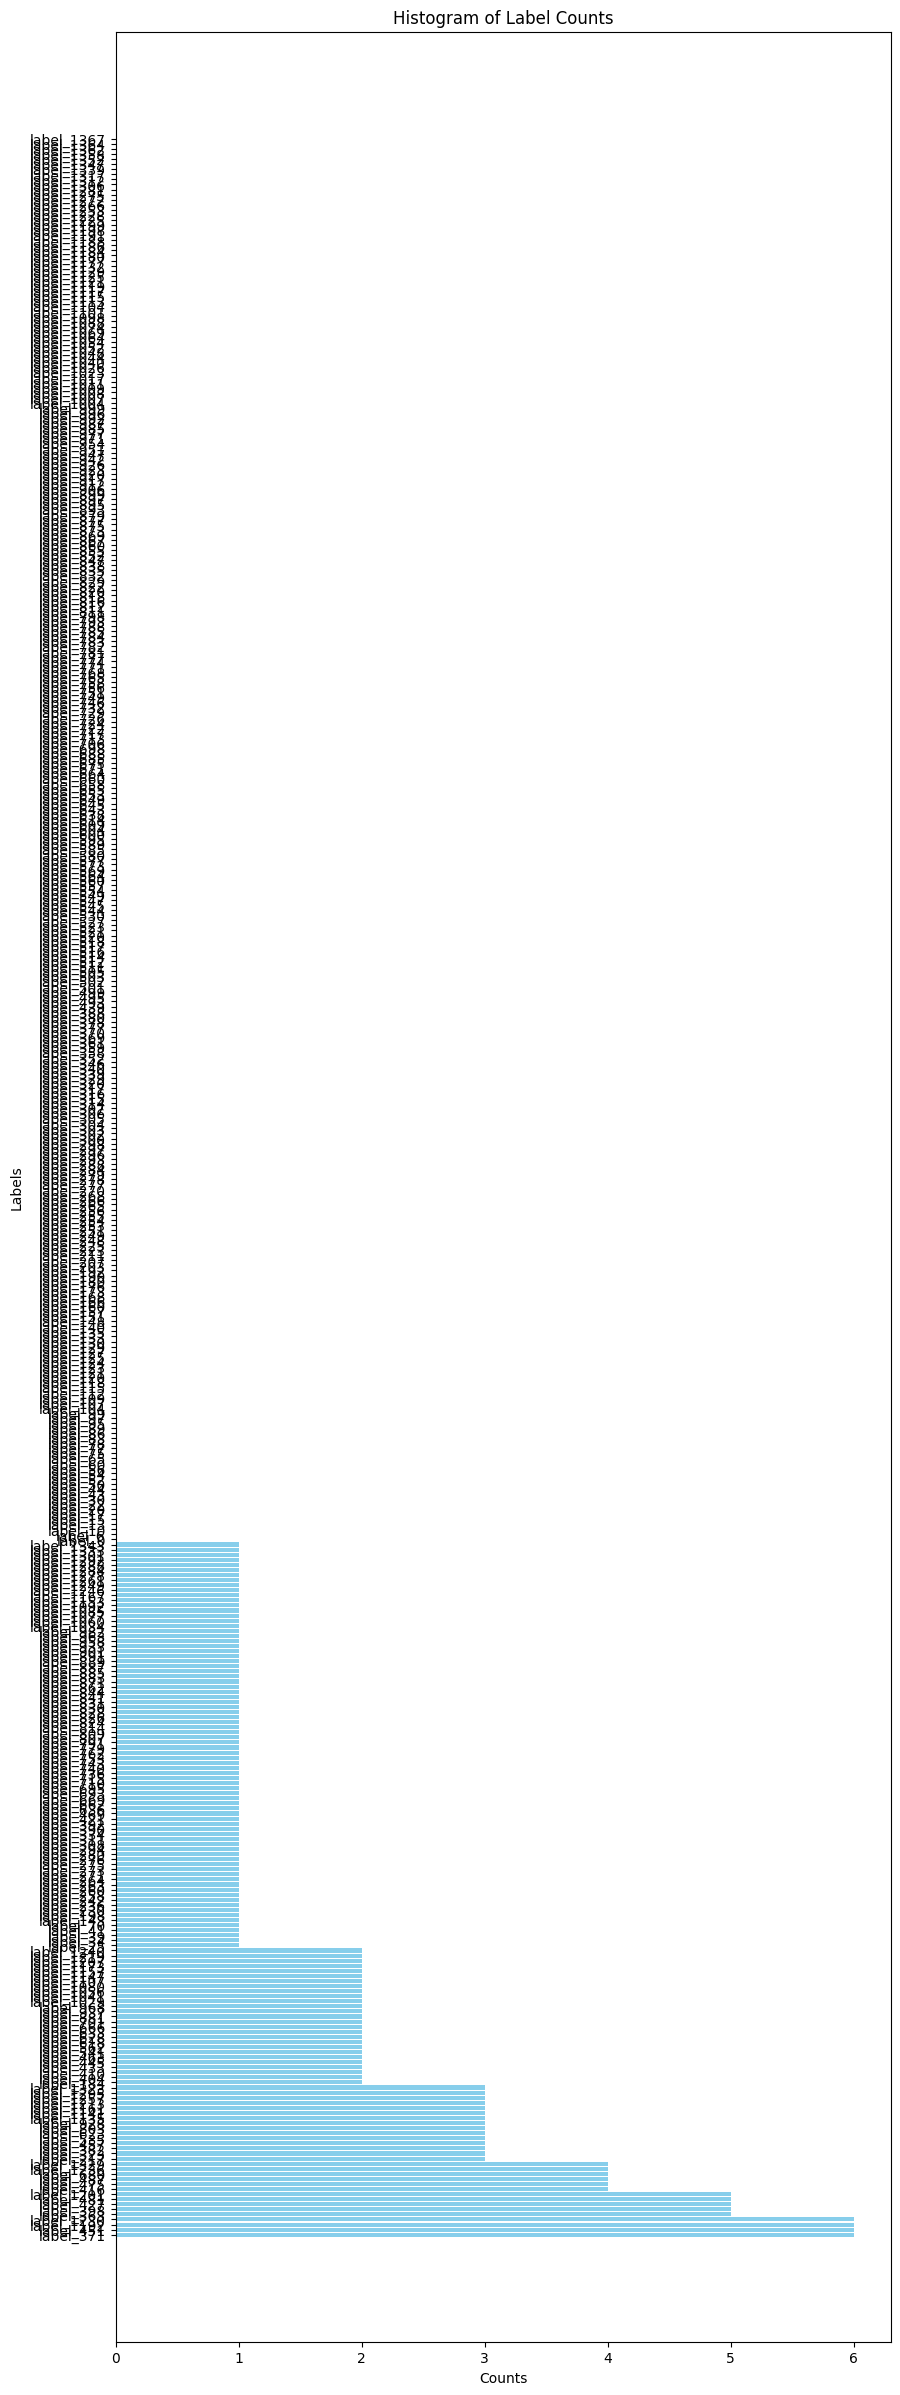

In [33]:
blobs_cat_counts_sorted = [(label, count) for label, count in blobs_cat_counts.items()]
blobs_cat_counts_sorted = sorted(blobs_cat_counts_sorted, key=lambda x: x[1], reverse=True)

labels = [i[0] for i in blobs_cat_counts_sorted]
counts = [i[1] for i in blobs_cat_counts_sorted]

plt.figure(figsize=(10, 30))
plt.barh(labels, counts, color='skyblue')  # Use barh for horizontal bar chart
plt.ylabel('Labels')
plt.xlabel('Counts')
plt.title('Histogram of Label Counts')

plt.show()

#### Filtering the classes with less annotations

In [34]:
threshold = 40

filtered_data = {key: value for key, value in blobs_cat_counts.items() if value > threshold}
print(f"Only {len(filtered_data)} classes have at least {threshold} number of examples")

Only 0 classes have at least 40 number of examples


In [35]:
# Perform the query
requirement_mappings = (
    session.query(
        RptRequirementsMapping.source,
        ComplianceItems.name,
        StandardsList.family,
        func.count().label('count')
    )
    .join(ComplianceItems, ComplianceItems.reporting_requirement_id == RptRequirementsMapping.reporting_requirement_id)
    .join(ValuesWithRevisions, ValuesWithRevisions.compliance_item_id == ComplianceItems.id)
    .join(StandardsList, StandardsList.id == RptRequirementsMapping.standard)
    .filter(StandardsList.family.like('%esrs%'))
    # .filter(ValuesWithRevisions.own_calculation == 1)
    .group_by(RptRequirementsMapping.source, ComplianceItems.name)
    .all()
)
actual_cat_map_2 = {}
for idx, cat_name  in enumerate(requirement_mappings):
    cat_name = cat_name[1]
    if cat_name not in actual_cat_map_2:
        actual_cat_map_2[cat_name] = f"label_{idx}"
requirement_mappings = [(req[0], actual_cat_map_2[req[1]], req[2], req[3]) for req in requirement_mappings]

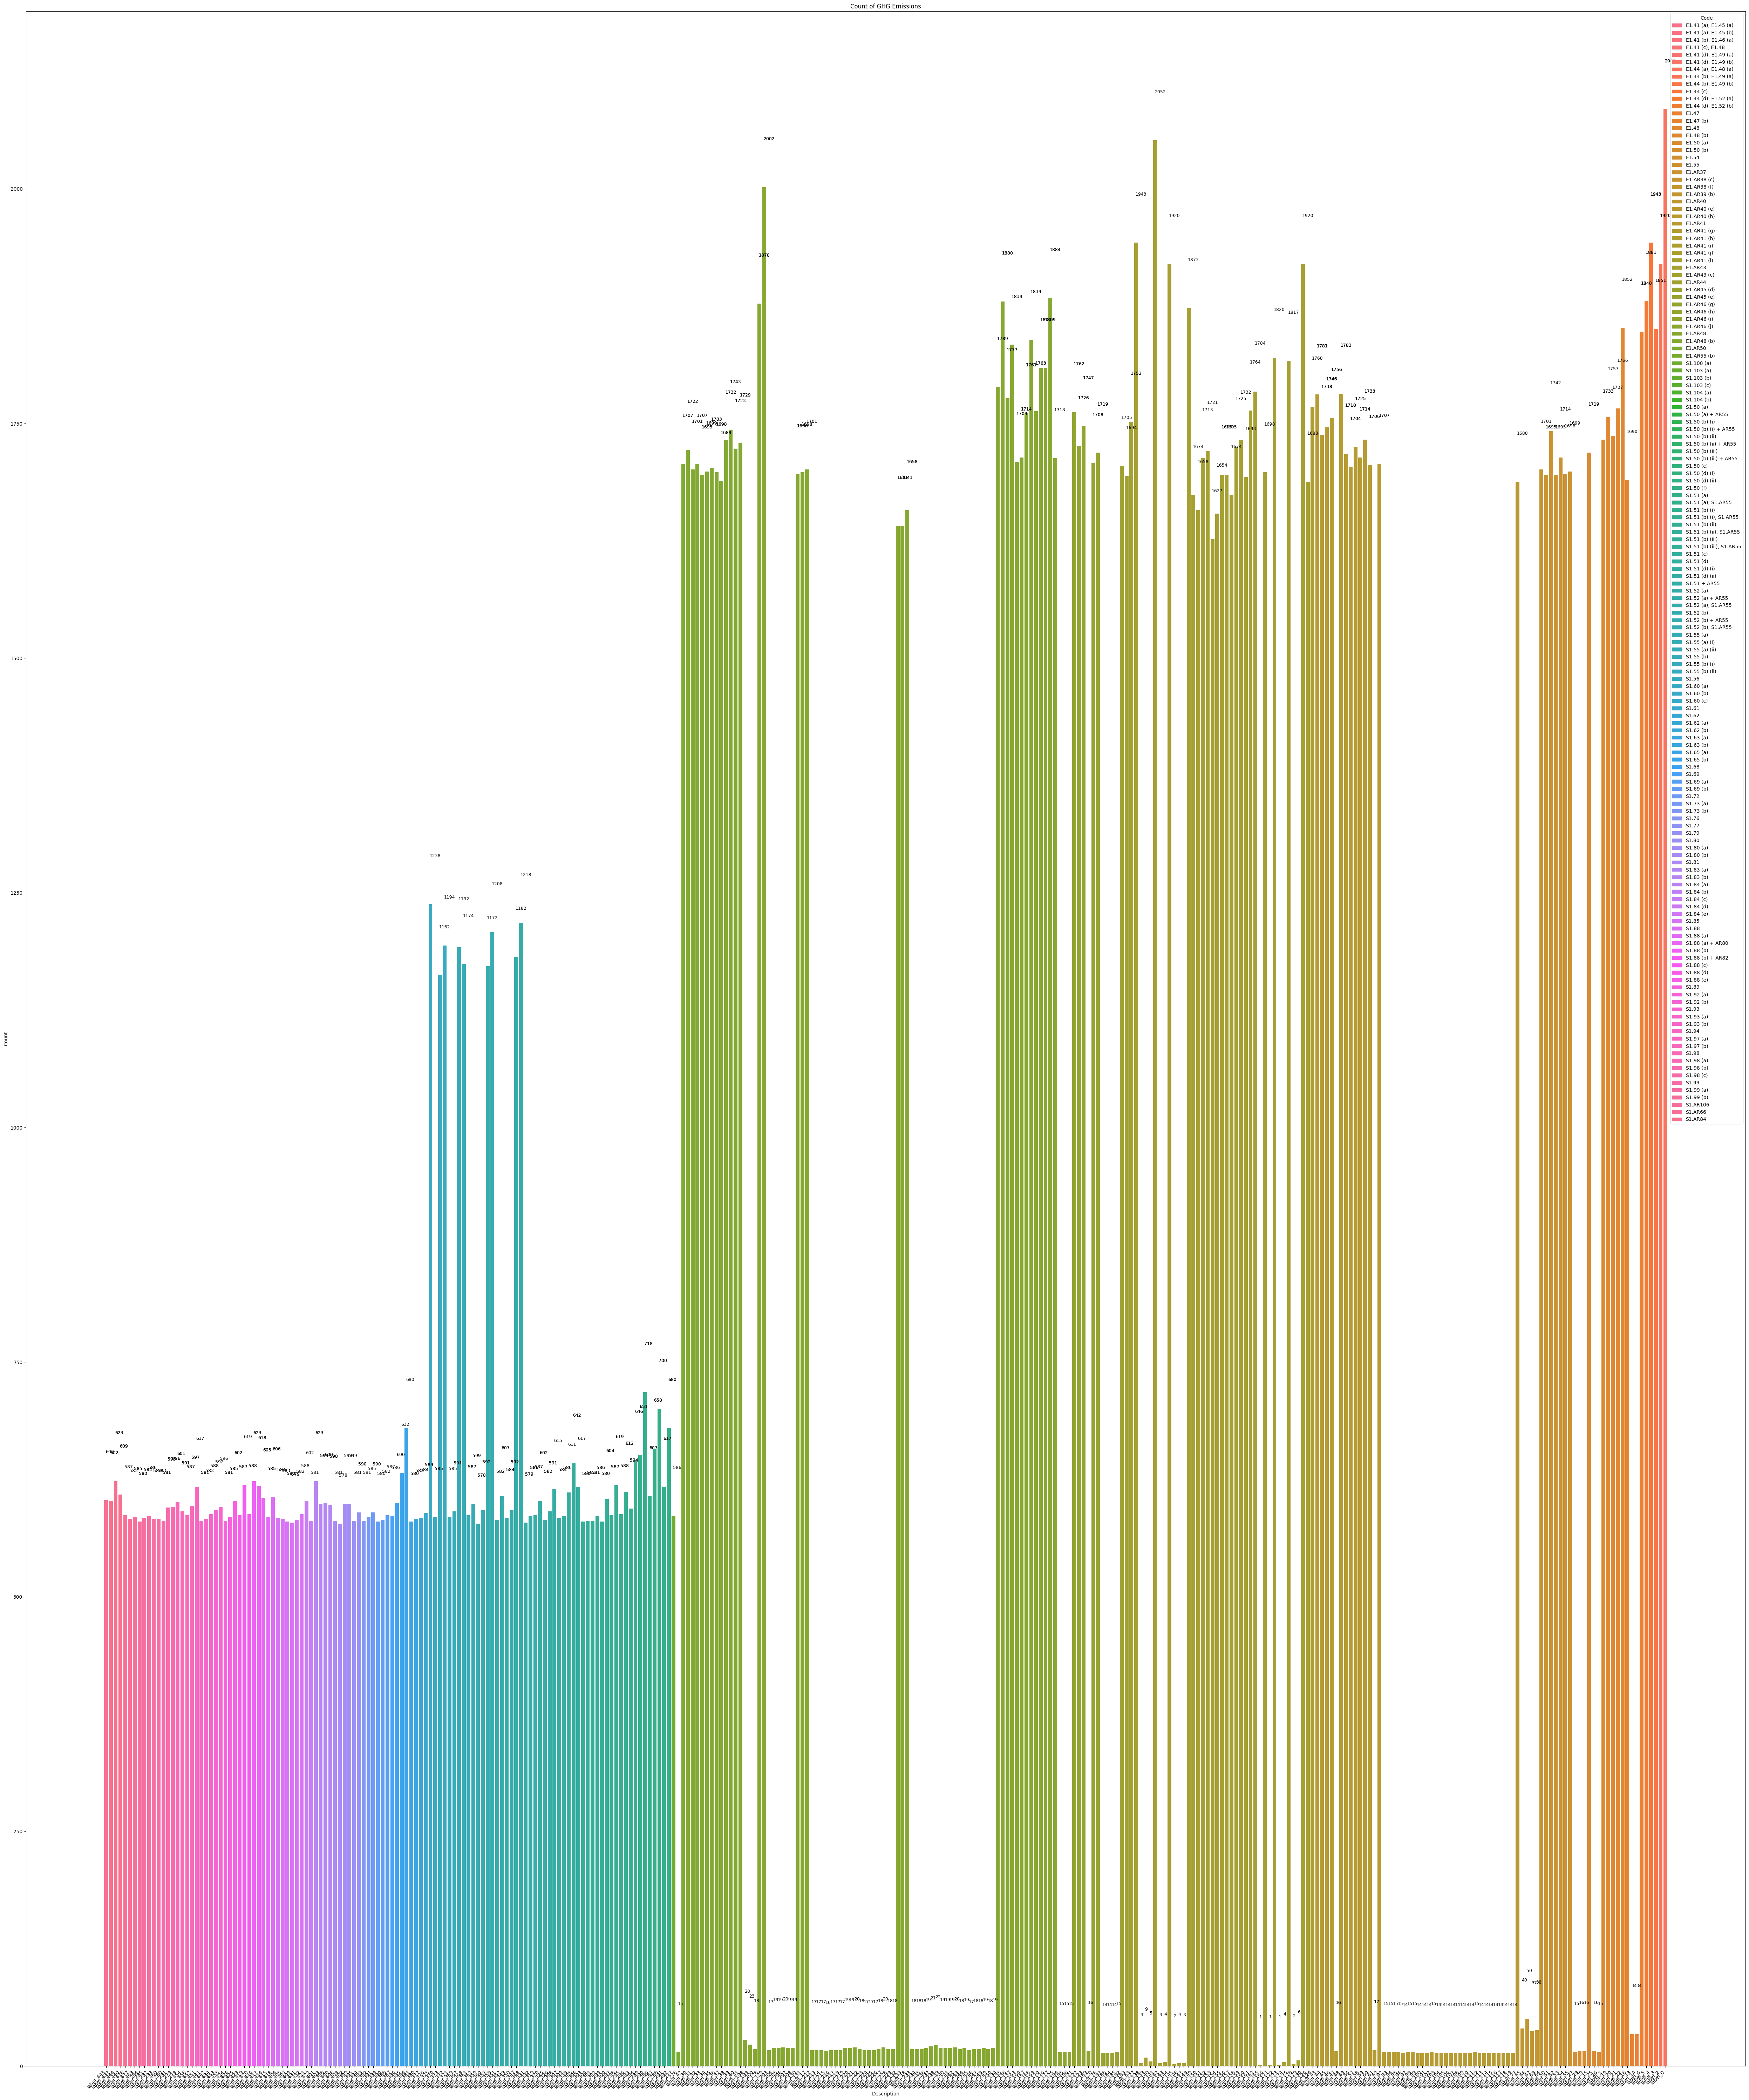

In [36]:
requirement_mappings = sorted(requirement_mappings, key=lambda x: x[0], reverse=True)
data = requirement_mappings


# Create a DataFrame
df = pd.DataFrame(data, columns=['Code', 'Description', 'Source', 'Count'])

# Extract relevant data for plotting
labels = df['Description']
counts = df['Count']
categories = df['Code']

# Group by the first value of the tuple (Code)
grouped_data = df.groupby('Code')

# Create a color palette
color_palette = sns.color_palette("husl", n_colors=len(grouped_data))

# Map colors to categories within each group
color_map = {}
for i, (group, data_group) in enumerate(grouped_data):
    color_map.update(dict(zip(data_group['Description'], [color_palette[i]] * len(data_group))))

# Plot the bar chart
plt.figure(figsize=(50, 60))
bars = plt.bar(labels, counts, color=[color_map[label] for label in labels])
plt.xlabel('Description')
plt.ylabel('Count')
plt.title('Count of GHG Emissions')

# Add legend
legend_labels = [plt.Rectangle((0, 0), 1, 1, color=color_palette[i]) for i in range(len(grouped_data))]
plt.legend(legend_labels, grouped_data.groups.keys(), title='Code')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Display count on top of each bar
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.15, bar.get_height() + 50, str(count), fontsize=9)

plt.tight_layout()

plt.savefig('classes_cnt_distribution.png')
# Show the plot
plt.show()

In [114]:
from llm_utils import LLMWrapper

/root/miniconda3/envs/llm_experiments/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [162]:
# model = LLMWrapper(model_name="gpt-3.5-turbo")
model = LLMWrapper(model_name="llama2-13b")

In [117]:
len(annotations)

7405

In [38]:
with Session(engine) as session:
    annnotations_data = (
        session.query(BlobLvlAnnotations.blob_text)
        .join(ValuesWithRevisions, BlobLvlAnnotations.revision_id == ValuesWithRevisions.id)
    ).all()

In [39]:
from tqdm import tqdm

In [42]:
print(f"{len(set(annnotations_data))} number of unique blobs that are annotated")

11406 number of unique blobs that are annotated


In [163]:
total_tokens_cnt = 0
for blob_data in tqdm(set(annnotations_data), desc='Counting tokens'):
    total_tokens_cnt += len(model.tokenizer.encode(text=blob_data[0]))

Counting tokens: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11406/11406 [00:07<00:00, 1440.57it/s]


In [164]:
print(f"{total_tokens_cnt} total annotated tokens")

4538543 total annotated tokens


In [165]:
total_tokens_cnt_unannotated = 0
for annotation in tqdm(annotations.items(), desc='Counting unannotated tokens'):
    json_data_path = os.path.join(dataset_path, annotation[1]['doc_location'])
    with open(json_data_path, 'r') as f:
        json_dict = json.load(f)
    all_page_data = [blob['text'] for page in list(json_dict.values()) for blob in page]
    for page_data in all_page_data:
        total_tokens_cnt_unannotated += len(model.tokenizer.encode(text=page_data))

Counting unannotated tokens: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7405/7405 [37:23<00:00,  3.30it/s]


In [167]:
print(f"{total_tokens_cnt_unannotated} total unannotated tokens")
print(f"{(total_tokens_cnt/total_tokens_cnt_unannotated) * 100} total unannotated tokens")

1103025636 total unannotated tokens
0.4114630568749537 total unannotated tokens


### Total number of tokens

| Model Name           | Total Annotated Tokens  | Total Unannotated Tokens| Annotated (in %)        |
| -------------------- | ----------------------- | ----------------------- | ----------------------- |
| `gpt-3.5-turbo`      | 3,437,252               | 8,43,873,410            | 0.407                   |
| `llama2-13b`         | 4,538,543               | 1,103,025,636           | 0.411                   |
